## 3.1 FPN – Feature Pyramid Network

C3 torch.Size([1, 512, 100, 100])
C4 torch.Size([1, 1024, 50, 50])
C5 torch.Size([1, 2048, 25, 25])
P3 shape: torch.Size([1, 256, 100, 100])
P4 shape: torch.Size([1, 256, 50, 50])
P5 shape: torch.Size([1, 256, 25, 25])


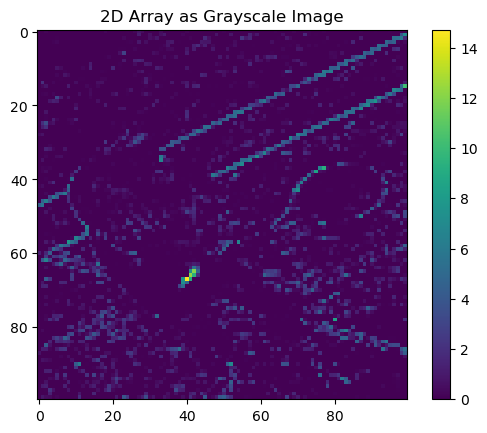

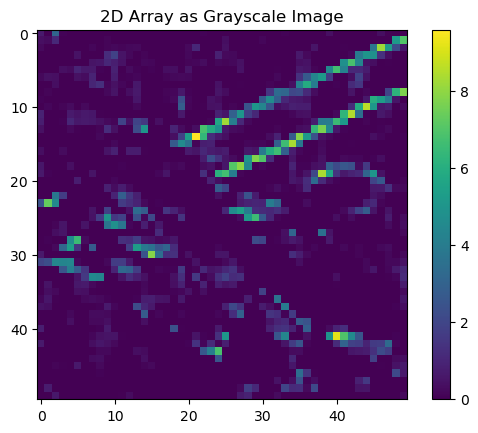

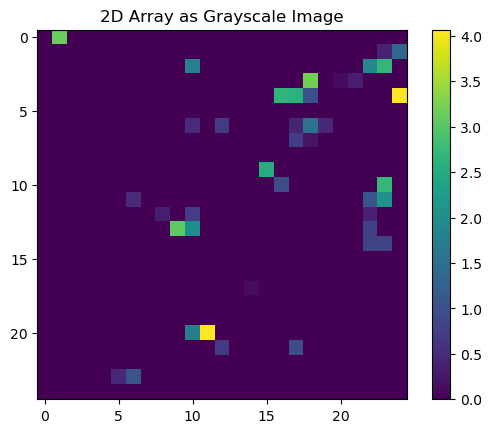

In [25]:
# modules_lab/01_fpn_demo_pytorch.py
import torch, torchvision
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img_path = "E:\\Pycharm\\Advanced-Reading-on-Computer-Vision\\Datasets\\VOC\\JPEGImages\\000000000962.jpg"  # thay bằng ảnh của bạn
img = Image.open(img_path).convert("RGB")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((800, 800)),  # dễ so kích thước
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
])
x = transform(img).unsqueeze(0)

# Lấy các feature từ ResNet50 (C3, C4, C5)
backbone = torchvision.models.resnet50(weights="IMAGENET1K_V2")
nodes = {"layer2": "C3", "layer3": "C4", "layer4": "C5"}
extractor = create_feature_extractor(backbone, return_nodes=nodes)
with torch.no_grad():
    feats = extractor(x)

for k, v in feats.items():
    print(k, v.shape)  # quan sát kích thước


# Gợi ý: thử tự xây FPN: P5 = conv(C5), P4 = conv(C4) + upsample(P5), ...
class SimpleFPN(torch.nn.Module):
    def __init__(self, in_channels_list, out_channels):
        super(SimpleFPN, self).__init__()
        self.lateral_convs = torch.nn.ModuleList()
        self.output_convs = torch.nn.ModuleList()
        for in_channels in in_channels_list:
            self.lateral_convs.append(torch.nn.Conv2d(in_channels, out_channels, kernel_size=1))
            self.output_convs.append(torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))

    def forward(self, inputs):
        C3, C4, C5 = inputs
        P5 = self.lateral_convs[2](C5)
        P4 = self.lateral_convs[1](C4) + torch.nn.functional.interpolate(P5, scale_factor=2, mode='nearest')
        P3 = self.lateral_convs[0](C3) + torch.nn.functional.interpolate(P4, scale_factor=2, mode='nearest')
        P5 = self.output_convs[2](P5)
        P4 = self.output_convs[1](P4)
        P3 = self.output_convs[0](P3)
        return P3, P4, P5


fpn = SimpleFPN(in_channels_list=[512, 1024, 2048], out_channels=256)
fpn_feats = fpn([feats["C3"], feats["C4"], feats["C5"]])
for i, f in enumerate(fpn_feats):
    print(f"P{i + 3} shape: {f.shape}")

import matplotlib.pyplot as plt

for k, v in feats.items():
    image_array = v[0, 10, :, :]
    plt.imshow(image_array)  # 'gray' colormap for grayscale images
    plt.colorbar()  # Optional: Add a color bar to show intensity mapping
    plt.title("2D Array as Grayscale Image")
    plt.show()

## 3.2 Anchors & RPN

Anchors: (22500, 4)


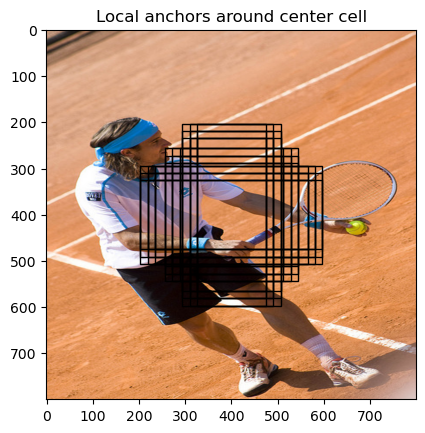

In [26]:
# modules_lab/02_rpn_anchor_demo.py
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def generate_anchors(base_size=32, ratios=(0.5, 1.0, 2.0), scales=(8, 16, 32)):
    anchors = []
    for s in scales:
        area = (base_size * s) ** 2
        for r in ratios:
            w = np.sqrt(area / r)
            h = w * r
            anchors.append([-w / 2, -h / 2, w / 2, h / 2])
    return np.array(anchors, dtype=np.float32)


def shift_anchors(feat_h, feat_w, stride, base_anchors):
    shifts_x = np.arange(0, feat_w) * stride
    shifts_y = np.arange(0, feat_h) * stride
    shift_x, shift_y = np.meshgrid(shifts_x, shifts_y)
    shifts = np.stack([shift_x.ravel(), shift_y.ravel(),
                       shift_x.ravel(), shift_y.ravel()], axis=1)
    A = base_anchors.shape[0]
    K = shifts.shape[0]
    all_anchors = (base_anchors.reshape((1, A, 4))
                   + shifts.reshape((K, 1, 4))).reshape(-1, 4)

    return all_anchors


# ví dụ: feature map 50x50, stride=16 → ảnh ~800x800
base_anchors = generate_anchors()
all_anchors = shift_anchors(50, 50, 16, base_anchors)
print("Anchors:", all_anchors.shape)  # ~ 50*50*len(ratios)*len(scales)

# Vẽ một số anchor quanh tâm
center = (25, 25)
idxs = []

for dy in range(-1, 2):
    for dx in range(-1, 2):
        y = (center[0] + dy) * 16
        x = (center[1] + dx) * 16
        # pick 3 anchors (1 scale)
        start = ((center[0] + dy) * 50 + (center[1] + dx)) * base_anchors.shape[0]
        idxs.extend([start, start + 1, start + 2])

img_path = "E:\\Pycharm\\Advanced-Reading-on-Computer-Vision\\Datasets\\VOC\\JPEGImages\\000000000962.jpg"  # thay bằng ảnh của bạn
img = Image.open(img_path).convert("RGB")
img = img.resize((800, 800))
plt.imshow(img)
ax = plt.gca()
for i in idxs:
    x1, y1, x2, y2 = all_anchors[i]
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth=1)
    ax.add_patch(rect)
plt.title("Local anchors around center cell")
plt.show()

## 3.3 RoI Pool vs RoI Align

C3 shape: (1, 512, 100, 100)
roi_feats shape: (2, 512, 7, 7)


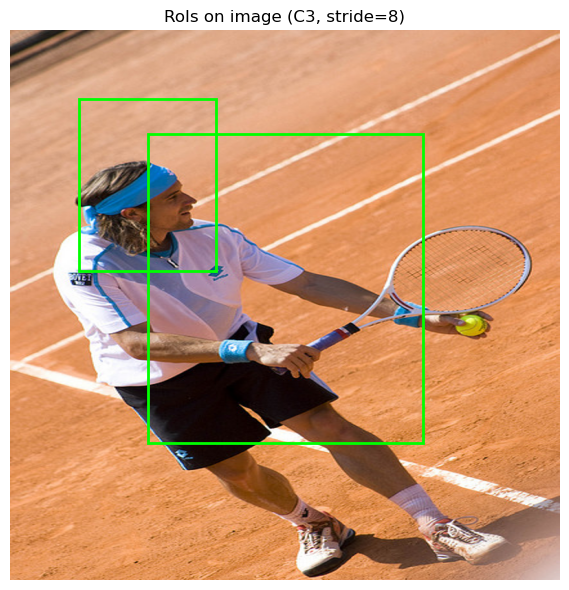

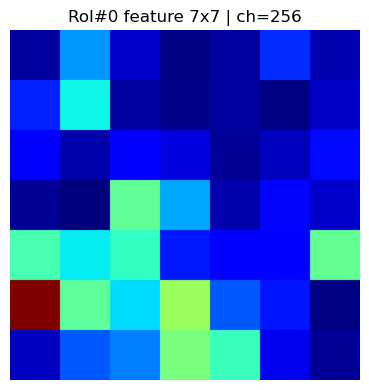

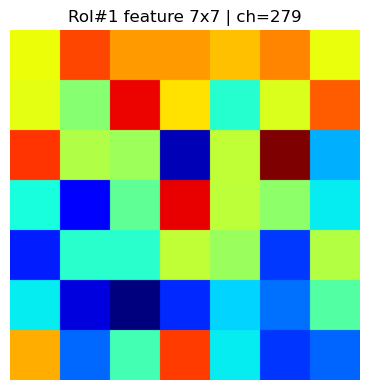

In [27]:
# modules_lab/03_roi_align_demo.py
import os, warnings, random
import torch, torchvision
import torch.nn.functional as F
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.ops import roi_align
from PIL import Image
import matplotlib.pyplot as plt

IMG_PATH = r"E:\\Pycharm\\Advanced-Reading-on-Computer-Vision\\Datasets\\VOC\\JPEGImages\\000000000962.jpg"  # đổi ảnh phù hợp
RESIZE_TO = (800, 800)
LEVEL     = "C3"
OUTPUT_SIZE = (7, 7)
SAMPLE_BOXES = [
    # (x1, y1, x2, y2) theo toạ độ ảnh sau khi resize
    (200, 150, 600, 600),
    (100, 100, 300, 350),
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img = Image.open(IMG_PATH).convert("RGB")
img_resized = img.resize(RESIZE_TO)
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485,0.456,0.406],
                                     std=[0.229,0.224,0.225]),
])
x = transform(img_resized).unsqueeze(0).to(device)   # [1,3,H,W]
H, W = RESIZE_TO

try:
    backbone = torchvision.models.resnet50(weights="IMAGENET1K_V2").to(device).eval()
except Exception as e:
    warnings.warn(f"Không tải được pretrained, dùng random weights. Lỗi: {e}")
    backbone = torchvision.models.resnet50(weights=None).to(device).eval()

nodes = {"layer2":"C3","layer3":"C4","layer4":"C5"}
extractor = create_feature_extractor(backbone, return_nodes=nodes)

with torch.no_grad():
    feats = extractor(x)      # dict: {"C3": [1,512,h3,w3], "C4":[1,1024,h4,w4], "C5":[1,2048,h5,w5]}
feat = feats[LEVEL]           # chọn 1 level để RoIAlign
_, C, h, w = feat.shape
print(f"{LEVEL} shape:", tuple(feat.shape))

# ResNet-50: C3~stride 8, C4~16, C5~32
stride_map = {"C3": 8, "C4": 16, "C5": 32}
stride = stride_map[LEVEL]
spatial_scale = 1.0 / stride   # rất quan trọng: boxes đang ở toạ độ ảnh, feature bị downsample

# torchvision.ops.roi_align nhận 'boxes' là list theo batch:
#  - batch size = 1  -> list dài 1
#  - phần tử là Tensor[K,4] toạ độ (x1,y1,x2,y2) theo toạ độ ảnh
boxes_list = [torch.tensor(SAMPLE_BOXES, dtype=torch.float32, device=device)]

with torch.no_grad():
    roi_feats = roi_align(        # output: [K, C, 7, 7]
        input=feat,
        boxes=boxes_list,
        output_size=OUTPUT_SIZE,
        spatial_scale=spatial_scale,
        sampling_ratio=-1,        # auto sampling (good default)
        aligned=True
    )
print("roi_feats shape:", tuple(roi_feats.shape))  # (K, C, 7, 7)

def show_boxes_on_image(pil_img, boxes, title="Boxes"):
    plt.figure(figsize=(6,6))
    plt.imshow(pil_img)
    ax = plt.gca()
    for (x1,y1,x2,y2) in boxes:
        rect = plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, linewidth=2, edgecolor="lime")
        ax.add_patch(rect)
    plt.title(title); plt.axis("off"); plt.tight_layout(); plt.show()

def show_roi_channel(roi_tensor, ch=None, up_to=224, title="RoI 7x7 (upsampled)"):
    if ch is None:
        ch = random.randint(0, roi_tensor.shape[0]-1)
    m = roi_tensor[ch]                          # [7,7]
    m = (m - m.min()) / (m.max()-m.min() + 1e-8)
    m_up = F.interpolate(m[None,None], size=(up_to, up_to), mode="nearest")[0,0].cpu().numpy()
    plt.figure(figsize=(4,4))
    plt.imshow(m_up, cmap="jet"); plt.title(f"{title} | ch={ch}")
    plt.axis("off"); plt.tight_layout(); plt.show()

show_boxes_on_image(img_resized, SAMPLE_BOXES, title=f"RoIs on image ({LEVEL}, stride={stride})")

with torch.no_grad():
    for i in range(min(2, roi_feats.shape[0])):            # xem tối đa 2 RoI demo
        show_roi_channel(roi_feats[i].cpu(), up_to=224, title=f"RoI#{i} feature 7x7")
